# Developing match up function

- Focus on wave rider buoys 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rompy
from rompy import utils ## Should we import utils in __init__.py?
from shapely.geometry import MultiPoint,Point
%matplotlib inline

xr.set_options(display_style = 'text')

In [2]:
cat = rompy.cat
model_ds = cat.csiro.swan.swan_perth_fc.map(fcdate='2021-02').to_dask()

x = model_ds.longitude.values.flatten().tolist()
y = model_ds.latitude.values.flatten().tolist()
points = MultiPoint(list(map(Point,zip(x,y))))
geom = points.convex_hull.buffer(0.5).simplify(tolerance=0.01)
df=cat.aodn.nrt_wave_buoys(startdt='2021-02',enddt='2021-04',geom=geom.to_wkt()).read()
obs = df[['TIME','LATITUDE','LONGITUDE','WHTH']].rename(columns={'TIME':'time','LATITUDE':'latitude','LONGITUDE':'longitude','WHTH':'hs'}).set_index(['time','latitude','longitude'])
obs_ds = xr.Dataset.from_dataframe(obs)
obs_ds['time'] = obs_ds['time'].astype(np.datetime64)

model_ds

<xarray.Dataset>
Dimensions:    (latitude: 300, longitude: 160, time: 121)
Coordinates:
  * time       (time) datetime64[ns] 2021-02-01 ... 2021-02-06
  * longitude  (longitude) float32 115.0 115.0 115.0 115.0 ... 115.8 115.8 115.8
  * latitude   (latitude) float32 -33.0 -32.99 -32.99 ... -31.51 -31.51 -31.5
Data variables:
    depth      (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    ubot       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    hs         (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    hswe       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    theta0     (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    tps        (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    tm01       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    xwnd       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
    ywnd       (time, latitude, longitude) float32 dask.array<chunksize=(24, 300, 160), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.5
    History:                         Created with agioncmd version 1.5
    Directional_convention:          nautical
    project:                         SWAN
    run:                             
    DODS_EXTRA.Unlimited_Dimension:  time

In [3]:
obs_ds

<xarray.Dataset>
Dimensions:    (latitude: 3, longitude: 3, time: 341)
Coordinates:
  * time       (time) datetime64[ns] 2021-02-01 ... 2021-04-01
  * latitude   (latitude) float64 -32.45 -32.1 -31.98
  * longitude  (longitude) float64 115.4 115.6 115.7
Data variables:
    hs         (time, latitude, longitude) float64 nan nan nan ... nan nan nan

In [4]:
out_ds = rompy.utils.find_matchup_data(obs_ds,model_ds,{'hs':'hs'},time_thresh=None)
out_ds

<xarray.Dataset>
Dimensions:          (ind: 2, latitude: 3, longitude: 3, observation: 3, time: 33)
Coordinates:
  * latitude         (latitude) float64 -32.45 -32.1 -31.98
  * longitude        (longitude) float64 115.4 115.6 115.7
  * time             (time) datetime64[ns] 2021-02-01 ... 2021-02-06
Dimensions without coordinates: ind, observation
Data variables:
    model_lon_idx    (longitude) int64 79 113 135
    model_lat_idx    (latitude) int64 110 179 203
    model_lon        (longitude) float32 115.4 115.6 115.7
    model_lat        (latitude) float32 -32.45 -32.1 -31.98
    model_dt         (time) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00
    meas_hs          (time, latitude, longitude) float64 nan nan ... nan 0.61
    model_hs         (time, latitude, longitude) float32 1.724 1.514 ... 1.012
    dist             (observation) float64 0.003116 0.002474 0.001774
    obs_latlon_inds  (observation, ind) int64 0 1 1 0 2 2
Attributes:
    grid:           regular
    KDtree params:  Default

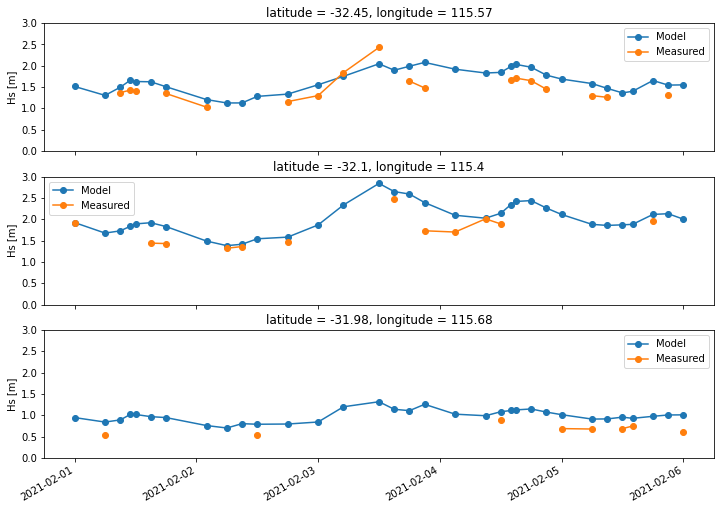

In [5]:
observations = out_ds['observation'].values
obs_latlon_inds = out_ds['obs_latlon_inds'].values

fig, axes = plt.subplots(nrows=len(observations),sharex=True,figsize=(12,8))

for obs,latlon in zip(observations,obs_latlon_inds):
    out_ds['model_hs'].isel({'latitude':latlon[0],'longitude':latlon[1]}).plot(ax=axes[obs],marker='o',label='Model')
    out_ds['meas_hs'].isel({'latitude':latlon[0],'longitude':latlon[1]}).plot(ax=axes[obs],marker='o',label='Measured')
    axes[obs].set_ylabel('Hs [m]')
    axes[obs].set_xlabel('')
    axes[obs].legend()
    axes[obs].set_ylim(0,3)

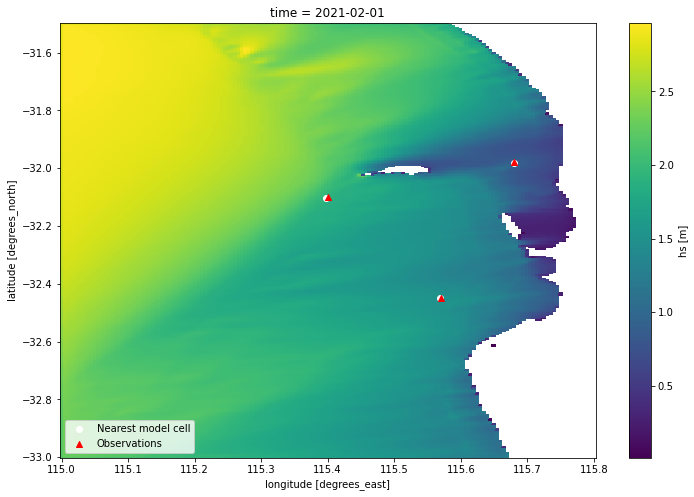

In [6]:
fig,ax =  plt.subplots(figsize=(12,8))

plt.scatter(out_ds['model_lon'].values[out_ds['obs_latlon_inds'].values[:,1]],out_ds['model_lat'].values[out_ds['obs_latlon_inds'].values[:,0]],label='Nearest model cell',c='white')
plt.scatter(out_ds['longitude'].values[out_ds['obs_latlon_inds'].values[:,1]],out_ds['latitude'].values[out_ds['obs_latlon_inds'].values[:,0]],label='Observations',marker='^',c='red')

model_ds['hs'].isel(time=0).plot(zorder=-1)
plt.legend(loc='lower left')